# Monte Carlo

We have previously explored [Policy Iteration](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/intro_rl_and_policy_iter.ipynb) and [Value Iteration](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/value_iteration.ipynb), and I will assume all of that as a prereq to this! We leveraged these iterative techniques to solve the Bellman Equation so we could play the game Frozen Lake:

![image](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake.gif?raw=true)

Although we were able to successfuly build our policy (that determines the optimal action to take at a state), there is a major limitation to Value/Policy iteration: You Need the MDP!! In our Frozen Lake Game, we had the following provided to us by the ```gymnasium``` package:

```python
state1: {action1:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],

         action2:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],
        ...}
state2: {action1:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],

         action2:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],
        ...}
...
```

This is the MDP of the game, that describes everything we need to know about the environment. For every state in the game, and for every action I take, what is the reward I will get and where could I end up? This is problematic as what if we need to solve an environment where we dont have the MDP? Unfortunately, the methods of Policy and Value iteration no longer work.

In both policy and value iteration, we try to estimate the values of the different states, and we could solve this by iteratively just solving the MDP. Now we have to leverage something else: Interactive Learning 

## Model Free Learning

If you dont have the model of the game, then its called Model Free Learning. This is the more practical case, in most situations in the real world, you dont have some nice dictionary describing all the states and actions. Instead, we can try to learn the dynamics of the environment by interacting with it and learning from experience. 

This literally means: Send your agent out into the game blind over and over again and slowly learn the game (and in the end estimate the values of the states)

The way we will explore today to do this is the Monte Carlo Method

### Monte Carlo Q(s,a) Values Estimation

Monte Carlo experiments are a method of just randomly sampling a bunch and then using the information gained from the samples to produce an estimate. This means, send out our agent into the frozen lake a bunch of times and just log all the trajectories of how things are going every time. Initially, the choices the agent will make is basically random, but we can use this information to start to update our knowledge of the game and improve the decision making.

When doing our Policy and Value iterations, remember that we never did ```env.step()``` when training our models. We only looked at our MDP and then once we had our best policy we applied it to the game. So then what are the steps of Monte Carlo?

So we first have a choice. We can either estimate the Values of a state (expected future rewards of a state) or we can estimate the Q Values (expected future rewards of a state and action). It seemed more intuitive to do this with the Q Function as we want to know the best action to take at every state, so that what I went with. We will repeat this for the Values afterwards as its basically the same idea, all that changes is our policy improvement method!

#### Steps:

1) The agent will interact with the environment. Every step will produce an tuple $(S_t, A_t, R_{t+1}, S_{t+1})$ which is a fancy way of saying, where am I now ($S_t$), what action did I take ($A_t$), what reward did I get ($R_{t+1}$) and where did I end up ($S_{t+1}$). We will then get a sequence of these until the game ends (reaches the prize or falls in a hole)
2) For every state we went to, we will calculate the estimated Q function $Q(s,a)$. What we want to estimate is the expected return of taking a specific action at a specific state, but how can we do this without the MDP? Well, we just completed a trajectory, so I know start to end exactly what happened. This means I can technically compute the future rewards at every state based on the experience I just had! There is obviously a lag here though, I can only update and learn once I have completed a full trajectory, we will solve that problem later!
5) We can repeat these trajectories a bunch of times, greedy updating our policy as we go!

### Lets Generate Trajectories

It would be helpful to have a function that can generate trajectories!

In [24]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("FrozenLake-v1", is_slippery=True)

def sample_trajectory(pi, env, max_steps=50, epsilon=0.1):

    """
    In this method we will play the game until 
    its either over or we hit max steps according
    to some policy PI

    Args:
        pi: The current policy
        env: The Game
        max_steps: Truncate trajectories longer than this
        epsilon: Inject some randomness for exploration
    """

    done = False
    trajectory = []
    num_steps = 0

    ### Start New Game ###
    state, _ = env.reset()
    
    while not done:

        ### Select Action According to Policy ###
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore random action
        else:
            action = pi[state]  # Exploit best known action

        ### Take a step in the environment ###
        next_state, reward, done, _, _= env.step(action)

        ### Create and Store your Experience Tuple ###
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)

        ### Iterate ###
        num_steps += 1

        if num_steps >= max_steps:
            done = False
            break

        ### Update current State to the Next State ###
        state = next_state

    return trajectory

### Initialize a Random Policy ###
policy = np.random.choice(env.action_space.n, size=(env.observation_space.n, ))
trajectory = sample_trajectory(policy, env)

print(trajectory)

[(0, 0, 0.0, 0, False), (0, 0, 0.0, 0, False), (0, 0, 0.0, 4, False), (4, 3, 0.0, 4, False), (4, 3, 0.0, 5, True)]


### Compute Future Returns

Now that we can generate trajectories, we need to be able to compute the future discounted rewards at every state we visited. Now a question you may have is, what if we visited a state multiple times? There are actually two variants of this:

- First Visit Monte Carlo: Only compute your future expected rewards for the first time you get to a state
- Every Visit Monte Carlo: Average up the future expected rewards for all times you visited a state

Today we will just do First Visit, but either would work!

#### Reminder: How to Compute Returns

Remember that $G_t$ is computed like the following:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$

### Computing returns $G_t$ (pretend we have 3 steps 0 -> 2):

- **At $t = 2$ (last step):**  
  $$
  G_2 = R_3
  $$

- **At $t = 1$ (second-to-last step):**  
  $$
  G_1 = R_2 + \gamma G_2
  $$

- **At $t = 0$ (first step):**  
  $$
  G_0 = R_1 + \gamma G_1
  $$

In [25]:
def compute_returns(trajectory, gamma=0.99):

    ### Create Empty Dictionary to Store Returns ###
    returns = {}

    ### Initialize Returns ###
    G = 0

    ### Reverse and Compute Returns ###
    for t in reversed(trajectory):

        state, action, reward, _, _ = t

        ### Compute new G ###
        G = reward + gamma * G

        ### First Visit Check ###
        if (state, action) not in returns:
            returns[(state, action)] = G

    return returns

compute_returns(trajectory)

{(4, 3): 0.0, (0, 0): 0.0}

### Monte Carlo Estimation of Q

Now that we can generate trajectories, we will do it over and over again, trying to estimate the Q function. We will do this by running a trajectory, computing its discounted returns (on the first visit) and then store those values. Then we can average up all the returns for every state/action pair and update Q

In [3]:
def monte_carlo_estimation(pi,
                           env, 
                           gamma=0.99, 
                           max_steps=50,
                           num_episodes=5000):

    ### Start Empty Q Values ###
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    returns = {(s, a): [] for s in range(env.observation_space.n) for a in range(env.action_space.n)}

    for _ in range(num_episodes):

        ### Sample a Trajectory ###
        trajectory = sample_trajectory(pi, env, max_steps)

        ### Compute Returns for Episode ###
        returns_for_episode = compute_returns(trajectory, gamma)

        ### Update Returns ###
        for (state,action), G in returns_for_episode.items():
            returns[(state,action)].append(G)

    ### Loop Through All the Accumulated Returns, Average Them Up and Update Q ###
    for (state, action), returns_list in returns.items():

        ### As Long as we had visits (we could have also not ever visisted a state) ###
        if len(returns_list) > 0:
            Q[state, action] = np.mean(returns_list)

    return Q
    
monte_carlo_estimation(policy, env)

array([[0.        , 0.00147674, 0.        , 0.00230529],
       [0.        , 0.        , 0.        , 0.00233432],
       [0.00549253, 0.00584016, 0.00332406, 0.        ],
       [0.00139346, 0.        , 0.        , 0.        ],
       [0.00477333, 0.        , 0.00504706, 0.00107607],
       [0.        , 0.        , 0.        , 0.        ],
       [0.00524007, 0.        , 0.01334161, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00993577],
       [0.        , 0.        , 0.00639475, 0.07315308],
       [0.12211233, 0.07071429, 0.28843821, 0.00463191],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.1225125 , 0.        , 0.14142857],
       [0.        , 0.        , 0.38047619, 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])

### Update Our Policy

Now that we have an estimate for our Q function, we can update our policy accoring to this Q Function. There are a few ways to do this, but easiest is a greedy selection of the highest value action in every state. 

In [4]:
def policy_improvement(Q):

    """
    Greedy select the action with the highest vlaue at every state
    """
    return np.argmax(Q, axis=-1)

### Toggle Between the Two

Just like in policy iteration where we toggled between estimating the Values function and then updating our policy, we will be toggling between estimating our Q function and then updating our policy.

**NOTE**

There are again tons of ways to do this. We could have also done an online estimation of our policy, updating it as we are estimating Q at the same time. Its really upto you! I am going for this toggle approach, because it lets me get a good estimate of Q first and then update the policy according to that

In [5]:
def monte_carlo_policy_iteration(env, 
                                 gamma=0.99, 
                                 max_steps=50, 
                                 num_episodes=10000):

    # Start with a random policy
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n, ))

    while True:
        # Policy Evaluation: Estimate Q(s,a) for the current policy
        Q = monte_carlo_estimation(policy, env, gamma, max_steps, num_episodes)

        # Policy Improvement: Generate a new policy based on the estimated Q(s,a)
        new_policy = policy_improvement(Q)

        # If the policy stops changing, we have converged
        if np.array_equal(policy, new_policy):
            break

        policy = new_policy  # Update policy for next iteration

    return policy, Q

optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)

print(optimal_policy)

[0 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0]


### Lets Test Our our Policy! ###

In [6]:
def test_policy(policy, env, num_episodes=500):
    success_count = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy[state]
            state, reward, done, _, _ = env.step(action)

            if done and reward == 1.0:  # Reached the goal
                success_count += 1

    success_rate = success_count / num_episodes
    print(f"Policy Success Rate: {success_rate * 100:.2f}%")

# Test the learned policy
test_policy(optimal_policy, env)

Policy Success Rate: 75.00%


### Sucess! 

Our method of exploring the environment to solve it works! 

### Bit More Efficiency

So one difference between what I did here and what you would find online is my update function for the Q Values. 

In my implementation I simply accumulate all my discounted rewards for my trajectories and then take an average at the end:

```python
### Loop Through All the Accumulated Returns, Average Them Up and Update Q ###
for (state, action), returns_list in returns.items():
    if len(returns_list) > 0:
        Q[state, action] = np.mean(returns_list)
```

Instead of doing this, we can do a running average and update Q every iteration. Not that it makes a difference, but lets try to match what we typically see. 

#### Running Mean

Lets say we have collected K returns for a particular State-Action pair (that is our list of returns). At the end we simply took a mean like the following:

$$Q_k = \frac{1}{k}\sum_{i=1}^kG_i$$

But this mean can only be taken at the end, in most online algorithms we want to be computed as we are going, so lets see how that happens. Assume then we have our average up to $Q_k$. Now we have recieved a new return $G_{k+1}$ and we want to compute our new $Q_{k+1}$. Then this would be just like before:

$$Q_{k+1} = \frac{1}{k+1}\sum_{i=1}^{k+1}G_i$$

We can then separate it like this:

$$Q_{k+1} = \frac{1}{k+1}\left[\left(\sum_{i=1}^{k}G_i\right) + G_{k+1}\right]$$

We can also rewrite $Q_k = \frac{1}{k}\sum_{i=1}^kG_i$ as $\sum_{i=1}^kG_i = k * Q_k$ and substitute!

$$Q_{k+1} = \frac{1}{k+1}\left[k * Q_k + G_{k+1}\right]$$
$$Q_{k+1} = \frac{k * Q_k}{k+1} + \frac{G_{k+1}}{k+1}$$

We can then use our age old, add one subtract one trick and write:

$$\frac{k}{k+1} = \frac{k+1-1}{k+1} = 1 - \frac{1}{k+1}$$

Lets substitute that back in:
$$Q_{k+1} = \left(1 - \frac{1}{k+1}\right) * Q_k + \frac{G_{k+1}}{k+1}$$
$$Q_{k+1} = Q_k - \frac{Q_k}{k+1} + \frac{G_{k+1}}{k+1}$$
$$Q_{k+1} = Q_k - \frac{1}{k+1}(G_{k+1} - Q_k)$$

And there we go! Our online averaging. Its just some dumb algebra, but thought it would be helpful to include just so its clear where this is coming from!

### Implement Online Monte Carlo 

In [7]:
def online_monte_carlo_estimation(pi,
                                  env,
                                  gamma=0.99,
                                  max_steps=50,
                                  num_episodes=5000):

    ### Start Empty Q Values ###
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    ### We Need to track our number of visits to each State/Action pair (K in the equation above) ###
    N = np.zeros((env.observation_space.n, env.action_space.n))

    for _ in range(num_episodes):
        ### Sample a Trajectory ###
        trajectory = sample_trajectory(pi, env, max_steps)

        ### Compute Returns for Episode (First Visit) ###
        returns = compute_returns(trajectory, gamma)

        ### Update Q based on first visits in this episode ###
        for (state, action), G in returns.items():
        

            ### Compute Q Value with Online Averating Formula ###
            Q[state, action] = Q[state, action] + (G - Q[state, action]) / (N[state, action] + 1)

            ### Iterate N for this State/Action Pair ###
            N[state, action] += 1


    return Q

### Update Policy Iteration Method

Policy iteration is the same as before! We just need to swap out our Monte Carlo estimator with our new online monte carlo estimator

In [16]:
def monte_carlo_policy_iteration(env, 
                                 gamma=0.99, 
                                 max_steps=50, 
                                 num_episodes=10000):

    # Start with a random policy
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n, ))

    while True:
        # Policy Evaluation: Estimate Q(s,a) for the current policy
        Q = online_monte_carlo_estimation(policy, env, gamma, max_steps, num_episodes)

        # Policy Improvement: Generate a new policy based on the estimated Q(s,a)
        new_policy = policy_improvement(Q)

        # If the policy stops changing, we have converged
        if np.array_equal(policy, new_policy):
            break

        policy = new_policy  # Update policy for next iteration

    return policy, Q

optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)

print(optimal_policy)

[0 3 2 3 0 0 2 0 3 1 0 0 0 2 1 0]


In [17]:
test_policy(optimal_policy, env)

Policy Success Rate: 73.00%


### Learning Rate

The final change we need to make is adding in a learning rate. In most implementations online you will see that instead of doing the following (what we just implemented above):

$$Q_{k+1} = Q_k - \frac{1}{k+1}(G_{k+1} - Q_k)$$

You will instead swap out our constant in front with some learning rate like the following:


$$Q_{k+1} = Q_k - \alpha_t(G_{k+1} - Q_k)$$

Where $\alpha_t$ is some time dependent learning rate parameter. We could have a scheduler, we could also just use a constant. For now lets just do a simple exponential scheduler!

#### Create a Simple Exponential Decay Scheduler

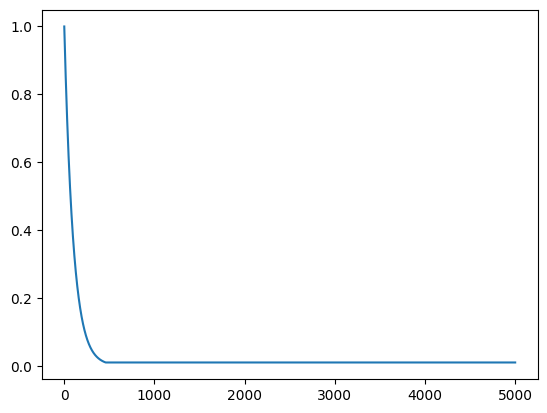

In [18]:
def lr_scheduler(start_val, min_val, decay_factor, num_episodes):

    alphas = [start_val * decay_factor**episode for episode in range(num_episodes)]
    alphas = [a if a >= min_val else min_val for a in alphas]

    return alphas

alphas = lr_scheduler(1.0, 0.01, 0.99, 5000)

plt.plot(alphas)
plt.show()


#### Update the Monte Carlo Estimator to use Learning Rate

In [19]:
def online_monte_carlo_estimation_w_lr(pi,
                                       env,
                                       gamma=0.99,
                                       max_steps=50,
                                       num_episodes=5000,
                                       lr_start_val=0.8, 
                                       lr_min_val=0.01, 
                                       lr_decay_factor=0.99):

    ### Start Empty Q Values ###
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    ### We Need to track our number of visits to each State/Action pair (K in the equation above) ###
    alphas = lr_scheduler(lr_start_val, lr_min_val, lr_decay_factor, num_episodes)

    for i in range(num_episodes):
        ### Sample a Trajectory ###
        trajectory = sample_trajectory(pi, env, max_steps)

        ### Compute Returns for Episode (First Visit) ###
        returns = compute_returns(trajectory, gamma)

        ### Update Q based on first visits in this episode ###
        for (state, action), G in returns.items():
        
            ### Compute Q Value with Online Averating Formula ###
            Q[state, action] = Q[state, action] + alphas[i] * (G - Q[state, action])


    return Q

### Update Policy Iteration Method

Policy iteration is the same as before! We just need to swap out our Monte Carlo estimator with our new online monte carlo estimator with learning rate

In [22]:
def monte_carlo_policy_iteration(env, 
                                 gamma=0.99, 
                                 max_steps=50, 
                                 num_episodes=10000,
                                 lr_start_val=0.6, 
                                 lr_min_val=0.01, 
                                 lr_decay_factor=0.98):

    # Start with a random policy
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n, ))

    while True:
        # Policy Evaluation: Estimate Q(s,a) for the current policy
        Q = online_monte_carlo_estimation_w_lr(policy, env, gamma, max_steps, num_episodes, lr_start_val, lr_min_val, lr_decay_factor)

        # Policy Improvement: Generate a new policy based on the estimated Q(s,a)
        new_policy = policy_improvement(Q)

        # If the policy stops changing, we have converged
        if np.array_equal(policy, new_policy):
            break

        policy = new_policy  # Update policy for next iteration

    return policy, Q

optimal_policy, optimal_Q = monte_carlo_policy_iteration(env)

print(optimal_policy)


[0 3 0 1 0 0 2 0 3 1 0 0 0 2 2 0]


In [23]:
test_policy(optimal_policy, env)

Policy Success Rate: 70.00%


### Thats it!

We have completed an important part of RL, Model Free Learning. Again, access to the MDP of an environment is basically impossible in most real world scenarios. So we used Monte Carlo to explore the environment and estimate the Q Values from its findings!

There is a clear limitation though, we can only learn after a trajectory. What if we wanted to learn as we are going? That is exactly what TD Learning does and what we will explore next!